In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
raw_pdf = pd.read_csv('dataKCx.csv')

opening_time = pd.Timestamp('06:55:00').strftime("%H:%M:%S")
raw_pdf.loc[raw_pdf['tradingphase'] == 'OPENING AUCTION','time'] = opening_time
closing_time = pd.Timestamp('15:30:00').strftime("%H:%M:%S")
raw_pdf.loc[raw_pdf['tradingphase'] == 'CLOSING AUCTION','time'] = closing_time

c_pdf = raw_pdf[(raw_pdf['tradingphase'] == 'CONTINUOUS') | (raw_pdf['tradingphase'] == 'OPENING AUCTION')]


raw_pdf['date_time'] = pd.to_datetime(raw_pdf['date'] + 'T' + raw_pdf['time'])
raw_pdf.set_index('date_time')
raw_pdf['cum_volume'] = raw_pdf.groupby(raw_pdf['date'])['volume'].cumsum()

In [14]:
raw_pdf.head()

,Unnamed: 0,date,time,volume,tradingphase,date_time,cum_volume
0,1,2020-03-30,06:55:00,466939.0,OPENING AUCTION,2020-03-30 06:55:00,466939.0
1,2,2020-03-30,07:00:00,199240.0,CONTINUOUS,2020-03-30 07:00:00,666179.0
2,3,2020-03-30,07:05:00,399928.0,CONTINUOUS,2020-03-30 07:05:00,1066107.0
3,4,2020-03-30,07:10:00,355929.0,CONTINUOUS,2020-03-30 07:10:00,1422036.0
4,5,2020-03-30,07:15:00,290592.0,CONTINUOUS,2020-03-30 07:15:00,1712628.0


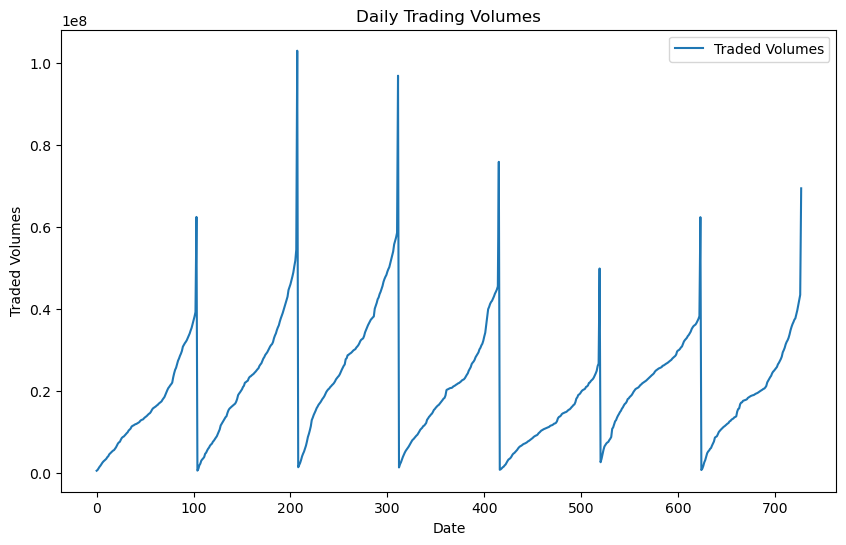

In [4]:
#plot all the data
ndays = 7
short_pdf = raw_pdf[:104*ndays]

plt.figure(figsize=(10, 6))
plt.plot(short_pdf.index, short_pdf['cum_volume'], label='Traded Volumes')
plt.xlabel('Date')
plt.ylabel('Traded Volumes')
plt.title('Daily Trading Volumes')
plt.legend()
plt.show()

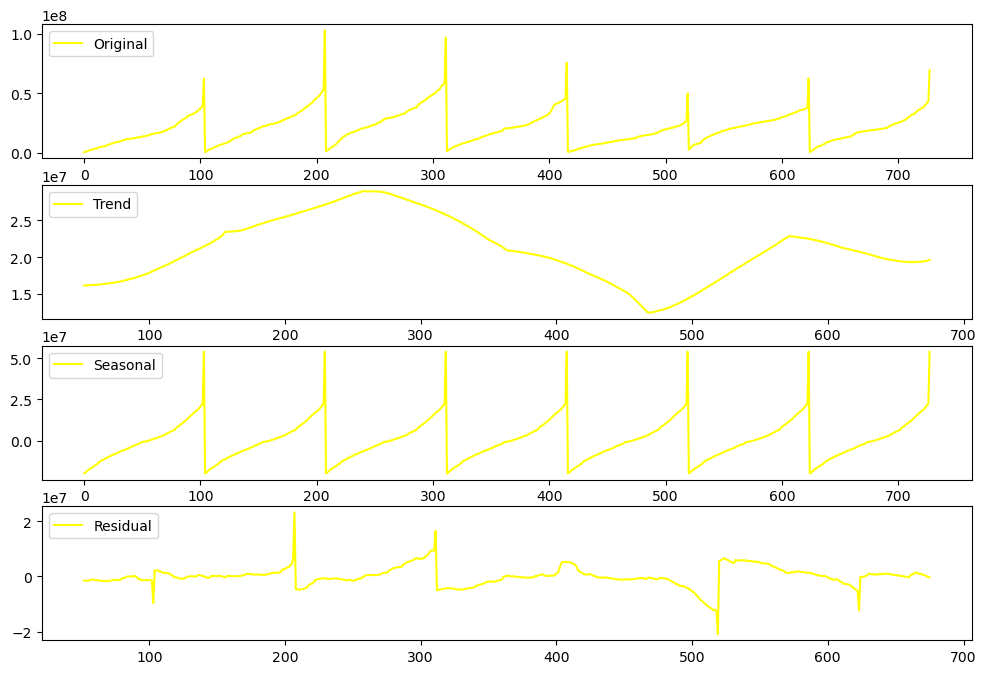

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposed = seasonal_decompose(short_pdf['cum_volume'],  
                            model ='additive',
                            period = 104)

trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(short_pdf['cum_volume'], label='Original', color='yellow')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='yellow')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='yellow')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='yellow')
plt.legend(loc='upper left')
plt.show()

In [7]:
from pmdarima.arima import auto_arima
#Autoarima gives us bet model suited for the data
# p - number of autoregressive terms (AR)
# q - Number of moving avergae terms (MA)
# d - number of non-seasonal differences
#p, d, q represent non-seasonal components
#P, D, Q represent seasonal components
arima_model = auto_arima(short_pdf['cum_volume'], start_p = 1, d=1, start_q = 1, 
                          max_p = 5, max_q = 5, max_d=5, m = 12, 
                          start_P = 0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          seasonal = True, 
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True, n_fits=50)           
  
# To print the summary 
print(arima_model.summary() ) #Note down the Model and details.

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=25093.196, Time=0.18 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=25199.558, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=24932.300, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=25109.562, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=24875.966, Time=0.97 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=24849.906, Time=3.49 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=24835.314, Time=7.20 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=24826.783, Time=17.22 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=42.97 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=21.34 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=24831.755, Time=10.21 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=24813.689, Time=15.81 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=24822.162, Time=9.11 sec
 ARIMA(2,1,0)(5,1,

In [5]:
#Split data into train and test
size = int(len(raw_pdf) * 0.8)
X_train, X_test = raw_pdf[0:size], raw_pdf[size:]

# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
#ARIMA(0, 1, 1)(5, 1, 0)[12]
#SARIMAX (0, 1, 1)x(5, 1, [], 12)

model = SARIMAX(X_train['cum_volume'],  
                order = (0, 1, 1),  
                seasonal_order =(5, 1, [], 12)) 
  
result = model.fit() 
result.summary() 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70365D+01    |proj g|=  7.60868D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      4      6      1     0     0   1.537D-06   1.704D+01
  F =   17.036427133909491     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          cum_volume   No. Observations:                54662
Model:             SARIMAX(0, 1, 1)x(5, 1, [], 12)   Log Likelihood             -931245.180
Date:                             Tue, 16 Jul 2024   AIC                        1862504.360
Time:                                     10:45:04   BIC                        1862566.721
Sample:                                          0   HQIC                       1862523.814
                                           - 54662                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4102      0.002   -261.850      0.000      -0.413      -0.407
ar.S.L12      -0.8407      0.005   -164.764      0.000      -0.851      -0.831
ar.S.L24      -0.6834      0.006   -106.200      0.000      -0.696      -0.671
ar.S.L36      -0.5112      0.007    -76.271      0.000      -0.524      -0.498
ar.S.L48      -0.3382      0.006    -54.275      0.000      -0.350      -0.326
ar.S.L60      -0.1670      0.005    -34.164      0.000      -0.177      -0.157
sigma2      5.646e+13   5.39e-17   1.05e+30      0.000    5.65e+13    5.65e+13
===================================================================================
Ljung-Box (L1) (Q):                   2.32   Jarque-Bera (JB):          10573618.82
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               1.41   Skew:                            -5.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        70.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.88e+44. Standard errors may be unstable.
"""

In [26]:
start_index = 0
end_index = len(X_train)-1
result.forecast()
#train_prediction = result.predict(start_index+104, end_index+104) 
#result.plot_diagnostics

ValueError: Prediction must have `end` after `start`.

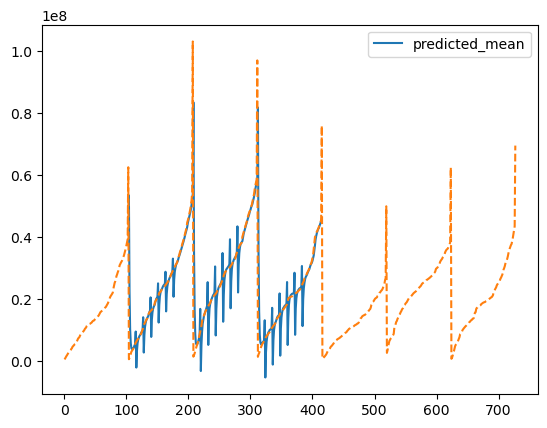

In [9]:
train_prediction[:104*3].plot(legend=True)
plt.plot(short_pdf.index, short_pdf['cum_volume'], label='Traded Volumes', linestyle = "dashed")


In [21]:
result.get_forecast(steps=X_train['cum_volume'][0:103])

KeyError: 'The `end` argument could not be matched to a location related to the index of the data.'